## Homework 1

#### Import dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier 
import pickle
import mlflow

In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_experiment")

<Experiment: artifact_location='file:///C:/Users/HP/Documents/mlops-zoomcamp2024/02-experiment-tracking/mlruns/1', creation_time=1716521166816, experiment_id='1', last_update_time=1716521166816, lifecycle_stage='active', name='nyc_experiment', tags={}>

## Prepare Data

### Import

In [3]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    drop_off = pd.to_datetime(df.tpep_dropoff_datetime) 
    pick_up = pd.to_datetime(df.tpep_pickup_datetime)

    df["duration"] = drop_off - pick_up
    df.duration = df.duration.apply(lambda td: td.total_seconds()/ 60)

    mask = ((df.duration >= 1) & (df.duration <= 60))
    df_fil = df[mask]
    
    # Calculate the fraction of records left after dropping the outliers
    fraction_left = len(df_fil) / len(df) * 100
    print("Fraction of records left after dropping outliers:", fraction_left)
    
    
    return df_fil

In [4]:
df_train = read_dataframe(r"yellow_tripdata_2023-01.parquet")

Fraction of records left after dropping outliers: 98.1220282212598


Solution to question 3 : The Fraction of the records left after dropping outliers is 98%

In [5]:
df_val = read_dataframe(r"yellow_tripdata_2023-02.parquet")

Fraction of records left after dropping outliers: 98.00944077722545


### Explore

In [6]:
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [7]:
# Check for the number of columns in the dataframe
df_train.shape

(3009173, 20)

Solution to question 1:
From the above dataframe there are 20 columns but note that a new column has been added by the read_dataframe function defined above. making the answer to the question 1 to be 19

In [8]:
# Check to confirm the datatype of the dataframe
df_train.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [9]:
# compute the descriptive statistics for the duration variable
df_train.duration.describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

Solution to question 2 : 
The standard deviation for the trip in January is 42.59 minutes.

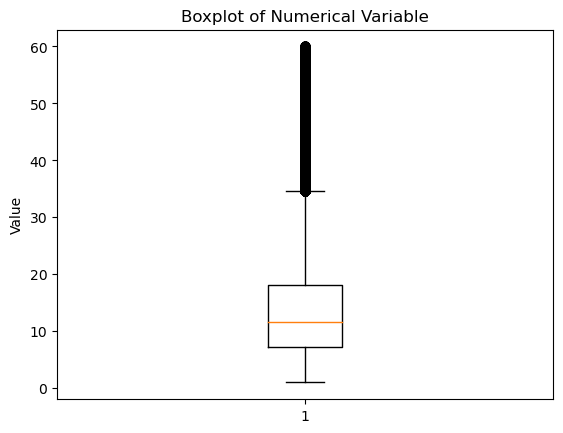

In [10]:
# Visualise the distribution of the duration variable
plt.boxplot(df_train['duration'])
plt.title('Boxplot of Numerical Variable')
plt.ylabel('Value')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_6548\3236285269.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train["duration"]);


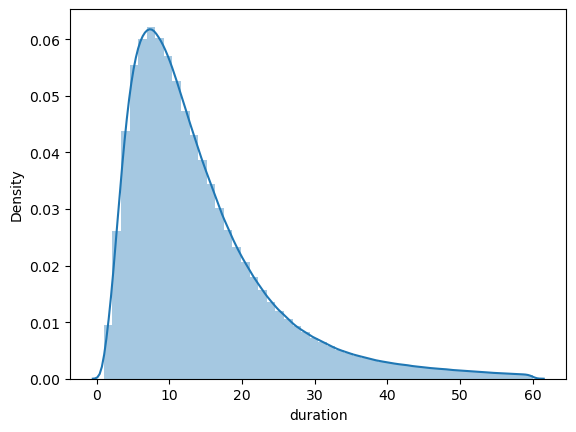

In [11]:
# visualize the distribution of the duartion variable
sns.distplot(df_train["duration"]);

## One-hot encoding of the categorical variables

In [12]:
# Apply one-hot encoding to the pickup and drop-off location id 
categorical = ["PULocationID", "DOLocationID"]

df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
X_train.shape

print("Dimensionality of the matrix:", X_train.shape[1])

Dimensionality of the matrix: 515


Solution to question 4:
Dimentionality of the matrix is 515.

## Train the model

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

train_rmse = mean_squared_error(y_train, y_pred, squared = False)

print('RMSE on train data:', train_rmse)

RMSE on train data: 7.649261959768939


Solution to question 5 : 7.6492610279057605

### Visualize the result

C:\Users\HP\AppData\Local\Temp\ipykernel_6548\3894165150.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = "prediction")
C:\Users\HP\AppData\Local\Temp\ipykernel_6548\3894165150.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train , label = "actual")


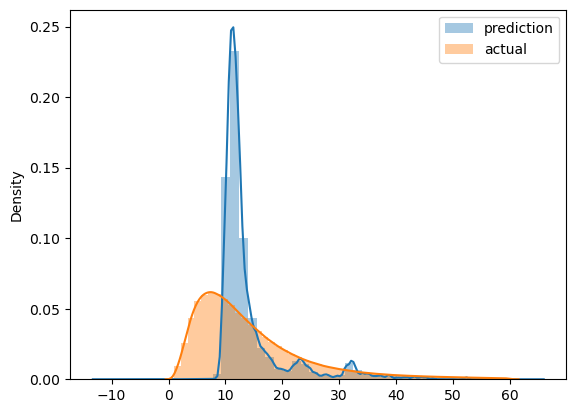

In [15]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train , label = "actual")
plt.legend();

In [16]:
val_pred = lr.predict(X_val)

val_rmse = mean_squared_error(y_val, val_pred, squared=False)

print('RMSE on validation data:', val_rmse)

RMSE on validation data: 7.811816826653192


Solution to question 6 : 7.81183265470218

## Save the file

In [17]:
with open("project1", 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run():
    
    mlflow.set_tag("dae", "tboy")
    
    mlflow.log_param("train", "yellow_tripdata_2023-01.parquet")
    mlflow.log_param("test", "yellow_tripdata_2023-02.parquet")
    
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.sklearn.log_model("model", "lasso_model")
    
    mlflow.log_artifact(local_path="project1", artifact_path="mlruns")

2024/05/24 14:25:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
C:\Users\HP\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [ ]:
# Import necessary libraries
import mlflow
import mlflow.sklearn
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the experiment name
experiment_name = "Iris Random Forest Experiment"

# Set the experiment in MLflow
mlflow.set_experiment(experiment_name)

# Start an MLflow run
with mlflow.start_run(run_name="Random Forest Run") as run:
    # Define hyperparameters
    n_estimators = 100
    max_depth = 5
    random_state = 42

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(train_x, train_y)
    
    # Make predictions on the test set
    predictions = model.predict(test_x)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(test_y, predictions)
    precision = precision_score(test_y, predictions, average="weighted")
    recall = recall_score(test_y, predictions, average="weighted")
    f1 = f1_score(test_y, predictions, average="weighted")
    
    # Log parameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("random_state", random_state)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Log the model
    mlflow.sklearn.log_model(model, "random_forest_model")
    
    # Print out the metrics for verification
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# End of the MLflow run
print(f"Run ID: {run.info.run_id}")


In [ ]:
from pathlib import Path
from mlflow import MlflowClient

# Create an experiment with a name that is unique and case sensitive.
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
experiment_id = client.create_experiment(
    "Social NLP Experiments",
    artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
    tags={"version": "v1", "priority": "P1"},
)
client.set_experiment_tag(experiment_id, "nlp.framework", "Spark NLP")

# Fetch experiment metadata information
experiment = client.get_experiment(experiment_id)
print(f"Name: {experiment.name}")
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")


In [ ]:
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [ ]:
from mlflow.tracking import MlflowClient

# Set the MLflow tracking URI
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

# Initialize the MLflow client
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

# List all experiments
experiments = client.list_experiments()

# Print the list of experiments
for exp in experiments:
    print(f"Experiment ID: {exp.experiment_id}, Name: {exp.name}, Artifact Location: {exp.artifact_location}, Lifecycle Stage: {exp.lifecycle_stage}")


In [ ]:
client.search_runs(
)